# SMALL-FOOTPRINT KEYWORD SPOTTING
## *FEATURE COMPARISON WITH A CNN*

The notebook show the behaviour of each feature used for representing the waveform as a spectrogram. The features are *short-time Fourier Transform* (STFT), *Mel-filterbank energy features* (fbank), *Mel Frequency Cepstral Coefficient* (MFCC) and *Discrete Wavelet Transform* (DWT). Once the waveform was transformed from the time-domain signals into the time-frequency-domain signals, we can train a CNN. The neural network is a basic CNN made of convolutional layers, pooling layers, dropout layers, and fully connected layers.

The main goal of the notebook is to train the same CNN using the four procedures for extracting the features. At the end, a comparison between the parameters - accuracy, loss and time - is performed in order to obatin the best approach.

#### Import libraries

In [2]:
import os
import soundfile
import pywt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.io import wavfile
from scipy.fftpack import dct
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras import layers
from tensorflow.keras import models
import IPython
from IPython.display import Audio
import visualkeras
import pandas as pd
from python_speech_features import mfcc, fbank

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. Dataset Loading

### Loading .wav files

In [4]:
def get_files(path):
    """
    Extract audio files from a folder

    Args:
        path: direction of the folder

    Return:
        saved: all the samples of the folders
        list_folders: labels of the folders
    """

    list_folders = sorted(os.listdir(path))
    saved = [0]*len(list_folders)

    for idx, audios in enumerate(list_folders):
        saved[idx] = os.listdir(os.path.join(path, audios))

    return(saved, list_folders)
        

### Tensorflow data creation

In [5]:
def tensorflow_creator(audio_samples, audio_labels, folder):
    """
    Convert data into tensorflow datasets

    Args:
        audio_samples: samples of the audio
        audio_labels: labels of the audio
        folder: general folder where all the label folders are

    Return:
        Tensorflow dataset
    """
    
    datasets = []

    for labels_idx, labels in enumerate(audio_labels):
        label_audio_s = os.path.join(folder, labels)
        label_audio = tf.data.Dataset.list_files(label_audio_s + "/*.wav")
        label_audio = tf.data.Dataset.zip((label_audio, tf.data.Dataset.from_tensor_slices(labels_idx*tf.ones(len(label_audio), dtype=tf.dtypes.int32))))
        datasets.append(label_audio)
    
    return datasets

def concatenate_tensorflow(data):
    """
    Concatenate tensorflow datasets

    Args:
        data: tensorflow dataset, the output of 'tensorflow_creator' function
    
    Return:
        Tensorflow dataset with audios of all labels
    """

    concatenated_data = data[0]
    for i in range (1, len(data)):
        concatenated_data = data[i].concatenate(concatenated_data)
    return concatenated_data


# Define a function to preprocess dataset elements and add shape information
def reshape_tf(float_tensor, int_tensor, string_tensor, size_1, size_2):
    """
    Reshape float and int tensorflow datasets 

    Args:
        float_tensor: float tensorflow dataset 
        int_tensor: int tensorflow dataset 
        size_1: size required for float_tensor
        size_2: size required for int_tensor

    Return:
        float_tensor: float tensorflow dataset with differet shape
        int_tensor: int tensorflow dataset with different shape
    """
    # Reshape or preprocess the float tensor to the expected shape
    # Example: Padding or truncating sequences
    float_tensor = tf.reshape(float_tensor, size_1)
    int_tensor = tf.reshape(int_tensor, size_2)

    return float_tensor, int_tensor, string_tensor

### Feature Creation

In [6]:
def combine_audio(phrase_path, label, noise="exercise_bike", apply_noise=True, noise_volume_scale=0.2, *args):
    """
    Combine a noise file with a word-audio file

    Args:
        phrase_path: the path where the audio file is
        label: label of each folder
        noise: type of noise you want to use. It can be choosen between,
            doing_the_dishes, dude_miaowing, exercise_bike, pink_noise, running_tap, white_noise
        apply_noise: if apply or not a noise 
        noise_volume_scale: controls the noise volume
    
    Return:
        waveform: a wave superposed with noise. The noise was taken from the 
            "background_noise" folder and reduced by a factor of 0.2.
    """

    phrase_audio, sample_rate= tf.audio.decode_wav(tf.io.read_file(phrase_path), desired_channels=1)
    phrase_audio = tf.squeeze(phrase_audio, axis = -1)
    desired_length = 16000
    padding_length = desired_length - tf.shape(phrase_audio)[0]
    padding = tf.zeros(padding_length, dtype=tf.float32)
    
    if padding_length % 2 == 0:
        padding1 = padding2 = padding[:padding_length // 2]
    else:
        padding1 = padding[:padding_length // 2]
        padding2 = padding[(padding_length // 2):]
        
    phrase_audio = tf.concat([padding1, phrase_audio, padding2], 0)


    if apply_noise: 
        
        noise_dict = {"doing_the_dishes": 0, "dude_miaowing": 1, "exercise_bike": 2, "pink_noise": 3, "running_tap": 4, "white_noise": 5}
        noise_path = "./background_noise"
        noise_opts = os.listdir(noise_path)

        # Load audio files
        
        noise_audio, _ = tf.audio.decode_wav(tf.io.read_file(os.path.join(noise_path, noise_opts[noise_dict.get(noise)])), desired_channels=1)
        noise_audio = tf.squeeze(noise_audio, axis = -1)

        start_position = tf.random.uniform([], maxval=len(noise_audio) - len(phrase_audio), dtype=tf.int32)

        noise_audio = noise_audio[start_position:start_position+len(phrase_audio)] * noise_volume_scale 
        phrase_audio = phrase_audio + noise_audio


    #phrase_audio = tf.squeeze(phrase_audio, axis = -1)
    #sample_rate = tf.cast(sample_rate, dtype = tf.int64)
    #phrase_audio = tfio.audio.resample(phrase_audio, rate_in= sample_rate, rate_out = 16000)


    # Export the combined audio to a new file
    return phrase_audio, label

In [7]:
def SIFT(wav, label):
    """
        Convert waveforms to spectrograms using short-time Fourier transform

        Args:
            wav: audio file
            label: labels of the audios
            phrase_audio: audio 

        Return:
            Spectrogram using short-time Fourier transform
        """
    spectrogram = tf.signal.stft(wav, frame_length = 256, frame_step = 128)
    spectrogram = tf.abs(spectrogram)
    #spectrogram = tf.math.log(tf.transpose(spectrogram))
    spectrogram = spectrogram[..., tf.newaxis]

    return spectrogram, label, wav

In [8]:
def MFCC(signal, label, 
            samplerate=16000, winlen=0.025, winstep=0.01, 
            numcep=13, nfilt=26, nfft=512, lowfreq=0, 
            highfreq=8000, preemph=0.97, ceplifter=22, 
            appendeEnergy=False, winfunc= np.hamming):
    """
    Compute MFCC features from an audio signal.

    Args:	
        signal: the audio signal from which to compute features. Should be an N*1 array
        label: labels of the audios
        samplerate: the samplerate of the signal we are working with.
        winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
        winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
        numcep: the number of cepstrum to return, default 13
        nfilt: the number of filters in the filterbank, default 26.
        nfft: the FFT size. Default is 512.
        lowfreq: lowest band edge of mel filters. In Hz, default is 0.
        highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
        preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
        ceplifter: apply a lifter to final cepstral coefficients. 0 is no lifter. Default is 22.
        appendEnergy: if this is true, the zeroth cepstral coefficient is replaced with the log of the total frame energy.
        winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    
    Returns:	
        A numpy array of size (NUMFRAMES by numcep) containing features. Each row holds 1 feature vector.
    """
    mfcc_feat = mfcc(signal, 
                             samplerate, 
                             winlen, 
                             winstep, 
                             numcep, 
                             nfilt, 
                             nfft, 
                             lowfreq, 
                             highfreq, 
                             preemph, 
                             ceplifter, 
                             appendeEnergy, 
                             winfunc)
    
    mfcc_spectrogram = tf.convert_to_tensor(mfcc_feat, dtype=tf.float32)

    mfcc_spectrogram = tf.reshape(mfcc_spectrogram, [1, 99, 13])
    
    return mfcc_spectrogram, label, signal

In [9]:
def DWT(waveform, label): #noise, apply_noise, noise_volume_scale):
  """
    Convert waveforms to spectrograms using Discrete Wavelet Transform

    Args:
        waveform: audio file
        label: labels of the audios
        noise: select the noise 
        apply_noise: True or False

    Return:
        Spectrogram using Discrete Wavelet Transform
    """

  # Convert the waveform to a spectrogram via a STFT.
  wavelet = 'db1'
  level = 4
  mode = 'sym'

  # Apply DWT
  coeffs = pywt.wavedec(waveform.numpy(), wavelet, level=level)
  spectrogram = pywt.waverec(coeffs, wavelet)
  spectrogram = tf.convert_to_tensor(spectrogram, dtype=tf.float32)
  #spectrogram, _ = pywt.dwt(data=waveform.numpy(), wavelet=wavelet, mode=mode)


  spectrogram = spectrogram[:15996]
  #spectrogram = tf.math.log(tf.transpose(spectrogram))
  spectrogram = tf.reshape(spectrogram, [1, 124, 129])

  return spectrogram, label, waveform

In [10]:
def Mel_filterbank(signal, label, 
            samplerate=16000, winlen=0.025, winstep=0.01, 
            nfilt=26, nfft=512, lowfreq=0, highfreq=8000, 
            preemph=0.97, winfunc= np.hamming):
    """
    Compute Mel-filterbank energy features from an audio signal.

    Args:	
        signal: the audio signal from which to compute features. Should be an N*1 array
        samplerate: the samplerate of the signal we are working with.
        winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
        winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
        nfilt: the number of filters in the filterbank, default 26.
        nfft: the FFT size. Default is 512.
        lowfreq: lowest band edge of mel filters. In Hz, default is 0.
        highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
        preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
        winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    Returns:	
        2 values. The first is a numpy array of size (NUMFRAMES by nfilt) containing features. Each row holds 1 feature vector. 
        The second return value is the energy in each frame (total energy, unwindowed)
    """
    fbank_feat, _ = fbank(signal, 
                             samplerate, 
                             winlen, 
                             winstep, 
                             nfilt, 
                             nfft, 
                             lowfreq, 
                             highfreq, 
                             preemph, 
                             winfunc)
    
    fbank_spectrogram = tf.convert_to_tensor(fbank_feat, dtype=tf.float32)

    fbank_spectrogram = tf.reshape(fbank_spectrogram, [1, 99, 26])
    
    return fbank_spectrogram, label, signal

In [11]:
def preprocess_tensor(data_folder):
    """
    Returns a shuffled concadenated tensor with path files and their labels.

    Args:
        data_folder -> path where files are located -> str

    Return: 
        Tensor with full path of file and labels ->tensor

    """

    with tf.device('/cpu:0'):
        # Search for .wav files in directory
        audio_samples, audio_labels = get_files(data_folder)

        # Create a tensor with labels and full path of .wav files
        audio_samples_tf = tensorflow_creator(audio_samples, audio_labels, data_folder)
        audio_samples_concatenated = concatenate_tensorflow(audio_samples_tf)
    
        # Shuffle tensor contents for good training
        audio_samples_concatenated = audio_samples_concatenated.shuffle(len(audio_samples_concatenated))

    return audio_samples_concatenated, audio_labels

In [12]:
# Create dataset
dir_wav = "./dataset"
audio_dataset, audio_labels = preprocess_tensor(dir_wav)

2024-07-13 23:38:53.183188: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-13 23:38:53.186550: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-13 23:38:53.189764: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# 2. Model Setup

 ### **2.1 Pipeline configuration**

For creating the model, first we need to create the dataset for the training procedure. The **tf.data** API enables us to build complex input pipelines from simple, reusable pieces. We are able to handle large amounts of data and perform complex operation. For this task, we will perform the following pipeline:

- **Do this operations with CPU device**
1. Create a Tensor element for storing the .wav files path and their respective labels.
2. Apply a **tf.map()** mapping transformation defined by **combine_audio**, this will apply background noise (if it is specified) and the apply feature extraction (STFT, DWT, MEL).
3. For training step, shape must be specified, therefore perform a reshape to the previously obtained tensor. 
4. Using **tf.take()** and **tf.skip()** split data for training, validation, test set. Sizes must be specified.
5. Prepare data for feeding model by applying **tf.batch()** and **tf.prefetch()**. The **tf.data.AUTOTUNE** allows us to find best choice for prefetching.
6. For accelerating training, **tf.cache()** can cache a dataset in memory for saving time in operations (opening or reading data) per epoch.

In [13]:
def pipeline_setup (dataset, feature_type, type_noise="exercise_bike" , add_noise = False, level_noise = 0, split = [0.7, 0.2],):
    """
    Return split dataset (training, validation, and test) for model training

    Args:
        dataset -> tensor with path files and labels -> tensor
        feature_type -> audio feature that will be used for model training -> str
        split -> partitions size for data splitting -> list
        apply_noise -> True if background noise is applied, and corresponding level -> list

    Return:
        Return training, validation and test sets. 

    """
    # Use CPU for all data preprocessing
    with tf.device('/cpu:0'):
    
        # Convert files into wavelength and apply feature extraction 
        
        dataset = dataset.map(lambda x, y: combine_audio(x,y, type_noise, add_noise, level_noise ), num_parallel_calls=tf.data.AUTOTUNE)
        if feature_type == SIFT:
            dataset = dataset.map(feature_type, num_parallel_calls=tf.data.AUTOTUNE)
        elif feature_type == DWT:
            dataset = dataset.map(lambda x, y: tf.py_function(feature_type, [x, y], [tf.float32, tf.int32, tf.float32]))#, num_parallel_calls=tf.data.AUTOTUNE))
        elif feature_type == MFCC:
            dataset = dataset.map(lambda x, y: tf.py_function(feature_type, [x, y], [tf.float32, tf.int32, tf.float32]))#, num_parallel_calls=tf.data.AUTOTUNE))
        elif feature_type == Mel_filterbank:
            dataset = dataset.map(lambda x, y: tf.py_function(feature_type, [x, y], [tf.float32, tf.int32, tf.float32]))#, num_parallel_calls=tf.data.AUTOTUNE))
        
        # Recompute shape
        tensor_shape = dataset.as_numpy_iterator().next()[0].shape
        dataset = dataset.map(lambda x, y, z: reshape_tf(x, y, z, size_1 = tensor_shape, size_2 =()))

        # Split datasets

        n_total = len(dataset)
        dataset_train = dataset.take(int(n_total*split[0]))
        dataset_test = dataset.skip(int(n_total*split[0]))
        dataset_val = dataset_test.skip(int(n_total*split[1]))
        dataset_test = dataset_test.take(int(n_total*split[1]))

        # Prepare pipeline
        batch_size = 64
        dataset_train = dataset_train.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        dataset_val = dataset_val.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        dataset_test = dataset_test.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        #dataset_train = dataset_train.cache()
        #dataset_val = dataset_val.cache()

    return dataset_train, dataset_val, dataset_test

### **2.2 Vainilla model**

The first model we are going to use is the one reported on: "Simple audio recognition: Recognizing keywords". <br>
This model has 2 **Conv2D**, a **Dense** layer and a **Resizing**. For speeding computations, **layers.Normalziation** is performed for the training set.<br>
For this we will use **Adam** as the optimizer and use the **SparceCategoricalCrossEntropy** as loss function.

In [14]:
from memory_profiler import profile
import time


def extract (tensor1, tensor2, tensor3):
    "Extract first two tensor elements"
    return tensor1, tensor2


@profile
def vanilla_model(training_data, validation_data, EPOCHS):
    """
    Create, compile and run a keras model for audio recognition.

    Args: 
        training_data -> tensor with audio features and labels -> tensor
        validation_data -> tensor with audio features and labels -> tensor
        EPOCHS -> number of epochs for running model -> int

    Return:
        Trained model and history with metrics
    
    """
    start_time = time.time()

    # Apply Layer normalization
    norm_layer = layers.Normalization()
    norm_layer.adapt(data=training_data.map(map_func=lambda spec, label: spec))

    # Reshape tensor for feeding into CNN
    shape_in = training_data.as_numpy_iterator().next()[0][0].shape
    print(shape_in)
    model = models.Sequential([
        layers.Input(shape=shape_in),
        layers.Resizing(32, 32),
        norm_layer,
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(audio_labels), activation='softmax'),
    ])

    

    # Compile model using ADAM and SparseCategoricalCrossEntropy
    model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

    print("Model Compiled succesfully\nStarting training")

    # Start fitting model with patience = 10
    history = model.fit(
    training_data,
    validation_data=validation_data,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=100),
    verbose = 1)

    end_time =time.time()
    print("Training done, model is ready to be tested!")
    

    return model, history, end_time-start_time


In [15]:
# Select audio feature extractor
feature_type = SIFT

# Define background noise
noise = False

# Run pipeline
train_data, val_data, test_data= pipeline_setup(audio_dataset, feature_type)

**Model Visualization**

For visualazing model previously created, it is used **visualkeras** as follows:

In [16]:
#visualkeras.layered_view(model, legend = True)
#model.save("vanilla_model")

### **2.3 Utilities functions**

For showing metrics and results, we created some functions that are imported from **utilities.py**.

In [17]:
from utilities import*

In [18]:
# Display training metrics dataframe
df = pd.DataFrame(history.history)
df.to_csv(os.path.join(df_path, 'stft_n.txt'), sep='\t', index=False)
df.tail()

NameError: name 'history' is not defined

# 3. Features testing

In [17]:
# Create folder for saving results
df_path = "./tests"
if not os.path.isdir(df_path): 

    os.makedirs(df_path) 

### **3.1 STFT**

For the first example, we will use the STFT as input data for training the model.

**Feature Extraction**

In [18]:
# Select audio feature extractor
feature_type = SIFT

# Define background noise
noise = False

# Run pipeline
train_data, val_data, test_data= pipeline_setup(audio_dataset, feature_type)

**Model training**

In [20]:
# Define epochs
number_epochs = 40

# Run model
model, history, total_time = vanilla_model(train_data.map(extract), val_data.map(extract), number_epochs)

ERROR: Could not find file /tmp/ipykernel_19434/2192404939.py
(124, 129, 1)
Model Compiled succesfully
Starting training
Epoch 1/40
1158/1158 [==============================] - 24s 19ms/step - loss: 2.1170 - accuracy: 0.4001 - val_loss: 1.0758 - val_accuracy: 0.7131
Epoch 2/40
1158/1158 [==============================] - 22s 18ms/step - loss: 1.3068 - accuracy: 0.6117 - val_loss: 0.8020 - val_accuracy: 0.7790
Epoch 3/40
1158/1158 [==============================] - 22s 18ms/step - loss: 1.1094 - accuracy: 0.6695 - val_loss: 0.6692 - val_accuracy: 0.8175
Epoch 4/40
1158/1158 [==============================] - 22s 19ms/step - loss: 1.0013 - accuracy: 0.7013 - val_loss: 0.5719 - val_accuracy: 0.8377
Epoch 5/40
1158/1158 [==============================] - 21s 18ms/step - loss: 0.9280 - accuracy: 0.7192 - val_loss: 0.5404 - val_accuracy: 0.8451
Epoch 6/40
1158/1158 [==============================] - 21s 17ms/step - loss: 0.8649 - accuracy: 0.7366 - val_loss: 0.4920 - val_accuracy: 0.8631
Epo

**Display training metrics**

In [37]:
# Display training metrics dataframe
df = pd.DataFrame(history.history)
df.to_csv(os.path.join(df_path, 'stft.txt'), sep='\t', index=False)
df.tail()


,loss,accuracy,val_loss,val_accuracy
5,0.841373,0.745680,0.471932,0.869331
6,0.795170,0.760219,0.457153,0.873772
7,0.762058,0.767751,0.413672,0.886338
8,0.720555,0.778915,0.383984,0.892101
9,0.694436,0.787311,0.338553,0.899660


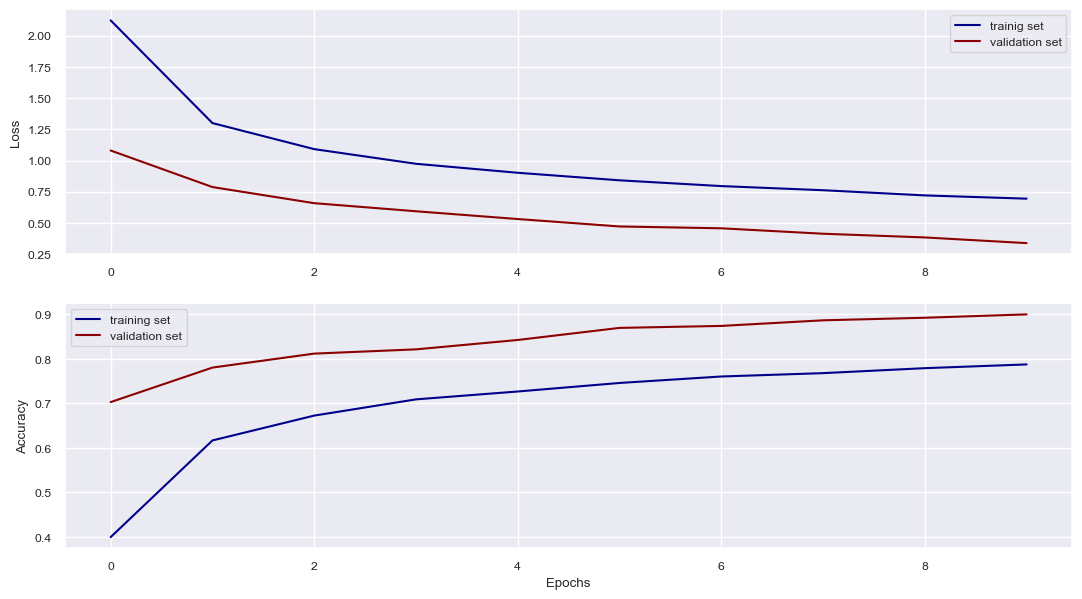

In [38]:
# Display convergence
training_metrics_plot(history)

**Predict labels in test set**

For analyzing model accuracy, we compute the predicted labels using the test set. We retrieve the true label and predicted with the probability.

In [39]:
# Obtain predictions on test set
names, real, predicted, probs= apply_test_data(test_data, model)

Then for a better understanding, a normalized confussion matrix is shown.

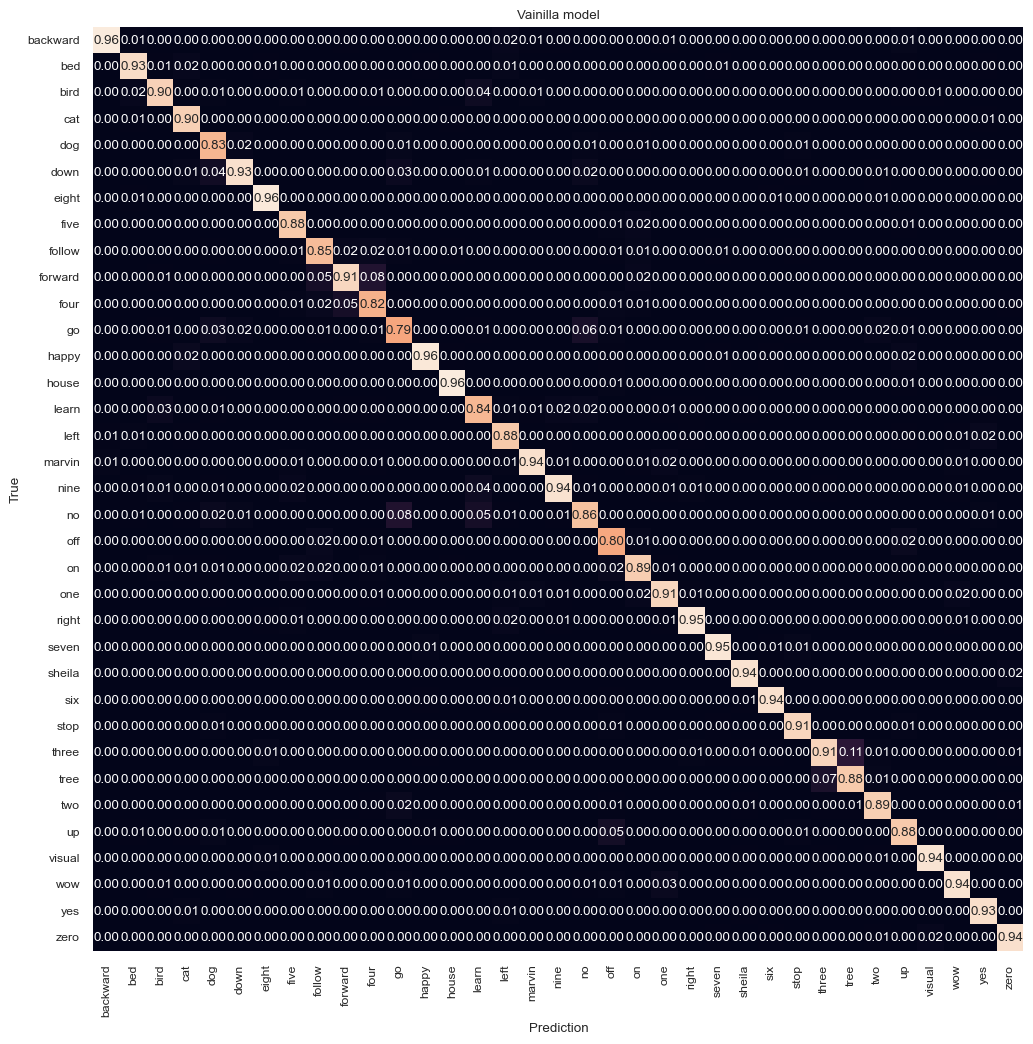

In [40]:
# Display confussion matrix
confussion_matrix(real, predicted, audio_labels)

We selected the samples misclassified and show the ones with the highest probability:

In [41]:
# Display the top worst classified samples
show_missclassified(names, real, predicted, probs,audio_labels, samples = 5)

-------------------
Example #0
Label: go | Predicted: down
Probability: 0.9884544014930725


-------------------
Example #1
Label: one | Predicted: on
Probability: 0.9839469194412231


-------------------
Example #2
Label: four | Predicted: on
Probability: 0.9807711243629456


-------------------
Example #3
Label: down | Predicted: stop
Probability: 0.9769396781921387


-------------------
Example #4
Label: three | Predicted: right
Probability: 0.9762656092643738


Finally, the overall metrics are:

In [42]:
# Evaluate model and display overall metrics
accuracy, loss = model.evaluate(test_data.map(extract), verbose = 0)
display_metrics(df, loss, accuracy, audio_dataset, names, total_time, number_epochs, feature_type, noise)

--------------------------------------------Model metrics--------------------------------------------

		TRAINING SET			VALIDATION SET			 TEST SET 
Accuracy:	0.7873110175132751		0.8996598720550537		0.8995984196662903
Loss:    	0.6944360733032227		0.33855289220809937		0.35563358664512634

Total samples: 105829
Misclassified samples: 21165

***MODEL SPECIFICATIONS***
Audio feature used: <function SIFT at 0x777f629c81f0>
Number of epochs: 10
Background noise: False
Noise level: 0

***BENCHMARKING***
Training time: 211.79982733726501


(0.7873110175132751, 0.6944360733032227)

In [28]:
# Save model
model.save("SIFT_40.keras")

### **3.2 SIFT + background noise**

Now, we will apply **bakground noise** with an intensity defined by **noise_level** to each of the .wav files. <br>
The background noise can be specified by tuninng **noise_type** parameter.

**Feature extraction**

In [15]:
# Select audio feature extractor
feature_type = SIFT

# Define background noise
noise = True
noise_level = 0.3
noise_type = "doing_the_dishes"

# Run pipeline
train_data, val_data, test_data= pipeline_setup(audio_dataset, feature_type, noise_type, noise, noise_level)

**Model training**

In [16]:
# Define epochs
number_epochs = 40

# Run model
model, history, total_time = vanilla_model(train_data.map(extract), val_data.map(extract), number_epochs)

ERROR: Could not find file /tmp/ipykernel_4224/2192404939.py
(124, 129, 1)
Model Compiled succesfully
Starting training
Epoch 1/40


2024-03-10 15:23:27.961339: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-10 15:23:28.332268: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-10 15:23:29.339383: I external/local_xla/xla/service/service.cc:168] XLA service 0x61bc1b59d0d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-10 15:23:29.339407: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-03-10 15:23:29.353160: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710080609.433532    4467 device_compiler.h:186] Compiled clust

1158/1158 [==============================] - 25s 18ms/step - loss: 2.2507 - accuracy: 0.3589 - val_loss: 1.3423 - val_accuracy: 0.6236
Epoch 2/40
1158/1158 [==============================] - 11s 9ms/step - loss: 1.5074 - accuracy: 0.5508 - val_loss: 1.0718 - val_accuracy: 0.6874
Epoch 3/40
1158/1158 [==============================] - 11s 9ms/step - loss: 1.3198 - accuracy: 0.6052 - val_loss: 0.9526 - val_accuracy: 0.7274
Epoch 4/40
1158/1158 [==============================] - 11s 9ms/step - loss: 1.2077 - accuracy: 0.6325 - val_loss: 0.9105 - val_accuracy: 0.7334
Epoch 5/40
1158/1158 [==============================] - 11s 9ms/step - loss: 1.1218 - accuracy: 0.6586 - val_loss: 0.8437 - val_accuracy: 0.7510
Epoch 6/40
1158/1158 [==============================] - 11s 9ms/step - loss: 1.0628 - accuracy: 0.6742 - val_loss: 0.8282 - val_accuracy: 0.7543
Epoch 7/40
1158/1158 [==============================] - 11s 9ms/step - loss: 1.0070 - accuracy: 0.6879 - val_loss: 0.8034 - val_accuracy: 0.

**Display training metrics**

In [17]:
# Display training metrics dataframe
df = pd.DataFrame(history.history)
df.to_csv(os.path.join(df_path, 'stft_n.txt'), sep='\t', index=False)
df.tail()

,loss,accuracy,val_loss,val_accuracy
35,0.555462,0.816415,0.733780,0.792139
36,0.549371,0.817441,0.753036,0.791761
37,0.541569,0.820275,0.777043,0.784486
38,0.534038,0.824217,0.780614,0.786092
39,0.533426,0.822719,0.784142,0.784108


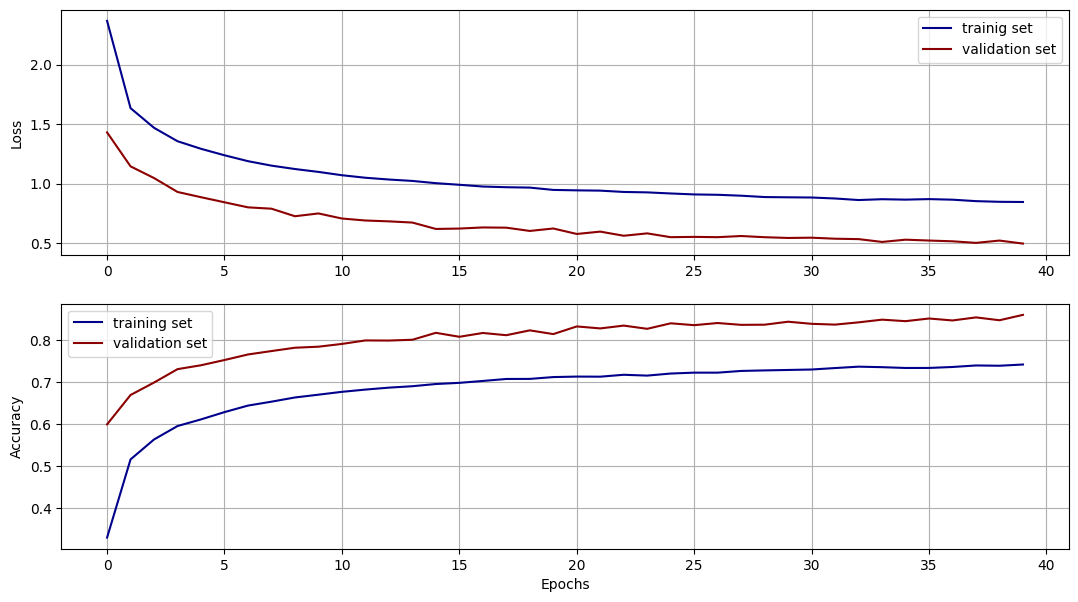

In [21]:
# Plot convergence (loss/accuracy)
training_metrics_plot(history)

**Predict labels in test set**

In [22]:
# Predict labels in test set
names, real, predicted, probs = apply_test_data(test_data, model)

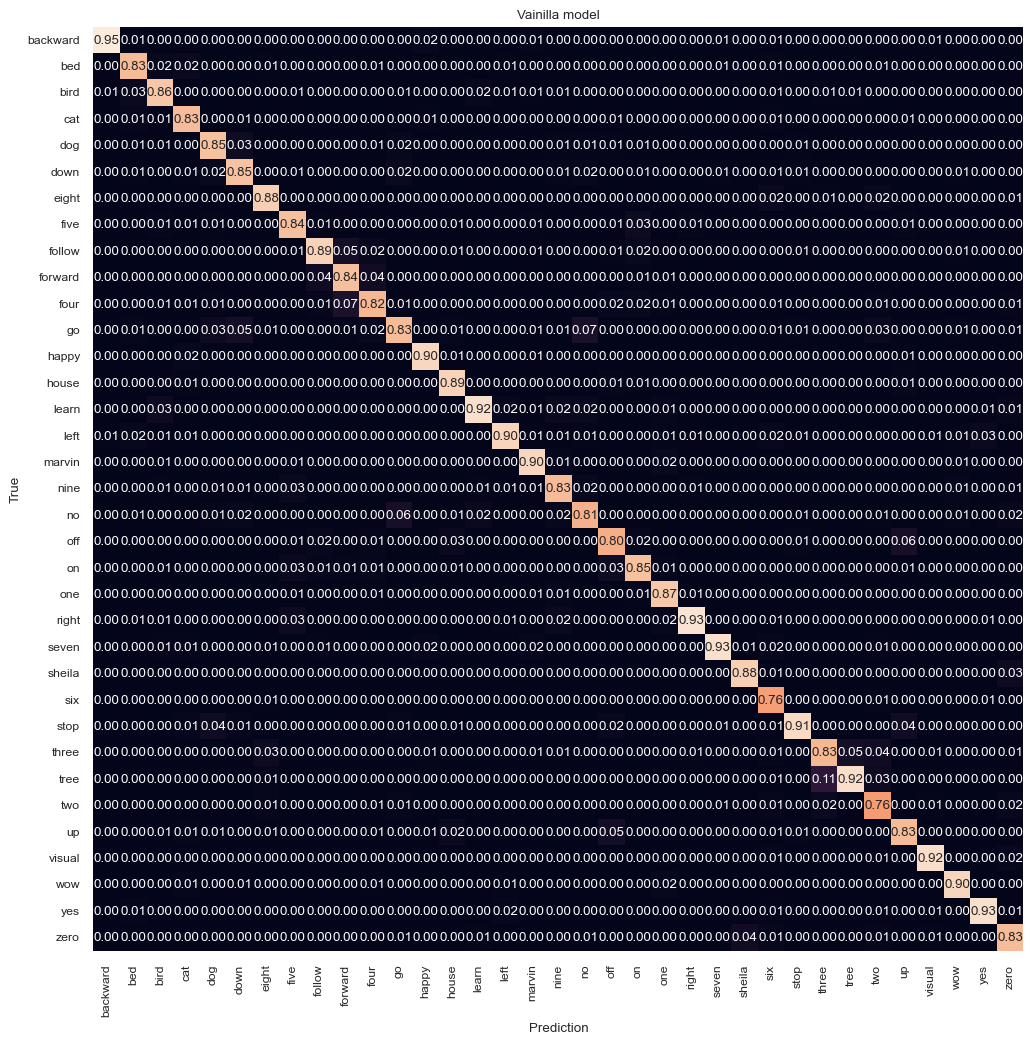

In [23]:
# Plot heatmap
confussion_matrix(real, predicted, audio_labels)

In [24]:
# Worst classified samples
show_missclassified(names, real, predicted, probs,audio_labels, samples = 5)

-------------------
Example #0
Label: on | Predicted: one
Probability: 0.9984440207481384


-------------------
Example #1
Label: down | Predicted: no
Probability: 0.9897317290306091


-------------------
Example #2
Label: wow | Predicted: left
Probability: 0.9893233180046082


-------------------
Example #3
Label: five | Predicted: bird
Probability: 0.9890941977500916


-------------------
Example #4
Label: learn | Predicted: bird
Probability: 0.9865582585334778


In [27]:
# Overall metrics
loss, accuracy = model.evaluate(test_data.map(extract), verbose = 0)
display_metrics(df, loss, accuracy, audio_dataset, names, total_time, number_epochs, feature_type, noise, noise_level)

--------------------------------------------Model metrics--------------------------------------------

		TRAINING SET			VALIDATION SET			 TEST SET 
Accuracy:	0.7421166300773621		0.8604497313499451		0.5013256072998047
Loss:    	0.8447737693786621		0.4950733482837677		0.8555161952972412

Total samples: 105829
Misclassified samples: 21165

***MODEL SPECIFICATIONS***
Audio feature used: <function SIFT at 0x7fbeed3bf6d0>
Number of epochs: 40
Background noise: True
Noise level: 0.3

***BENCHMARKING***
Training time: 827.980714559555


### **3.3 DWT + background noise**

Now, the input features will be extracted using DWT and adding background noise as in the previous case.

**Feature extraction**

In [28]:
# Select audio feature extractor
feature_type = DWT

# Define background noise
noise = True
noise_level = 0.3
noise_type = "doing_the_dishes"

# Run pipeline
train_data, val_data, test_data= pipeline_setup(audio_dataset, feature_type, noise_type, noise, noise_level)

**Model training**

In [29]:
# Define epochs
number_epochs = 40

# Run model
model, history, total_time = vanilla_model(train_data.map(extract), val_data.map(extract), number_epochs)

ERROR: Could not find file /tmp/ipykernel_25613/2192404939.py
(1, 124, 129)
Model Compiled succesfully
Starting training
Epoch 1/40


2024-03-09 15:32:20.993151: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1158/1158 [==============================] - 162s 138ms/step - loss: 3.4287 - accuracy: 0.0630 - val_loss: 3.1787 - val_accuracy: 0.1115
Epoch 2/40
1158/1158 [==============================] - 157s 135ms/step - loss: 3.1286 - accuracy: 0.1234 - val_loss: 2.8368 - val_accuracy: 0.1882
Epoch 3/40
1158/1158 [==============================] - 156s 135ms/step - loss: 2.9382 - accuracy: 0.1670 - val_loss: 2.6421 - val_accuracy: 0.2337
Epoch 4/40
1158/1158 [==============================] - 157s 136ms/step - loss: 2.8316 - accuracy: 0.1910 - val_loss: 2.5258 - val_accuracy: 0.2665
Epoch 5/40
1158/1158 [==============================] - 157s 135ms/step - loss: 2.7501 - accuracy: 0.2110 - val_loss: 2.5155 - val_accuracy: 0.2688
Epoch 6/40
1158/1158 [==============================] - 157s 135ms/step - loss: 2.6937 - accuracy: 0.2219 - val_loss: 2.4089 - val_accuracy: 0.2943
Epoch 7/40
1158/1158 [==============================] - 156s 135ms/step - loss: 2.6599 - accuracy: 0.2323 - val_loss: 2.367

 **Display training metrics**

In [34]:
# Display training metrics dataframe
df = pd.DataFrame(history.history)
df.to_csv(os.path.join(df_path, 'dwt_n.txt'), sep='\t', index=False)
df.tail()

,loss,accuracy,val_loss,val_accuracy
35,2.444952,0.280008,2.149922,0.361961
36,2.451277,0.281682,2.163493,0.351190
37,2.452728,0.282033,2.116935,0.368953
38,2.442507,0.283072,2.153496,0.361772
39,2.452253,0.282735,2.151848,0.365552


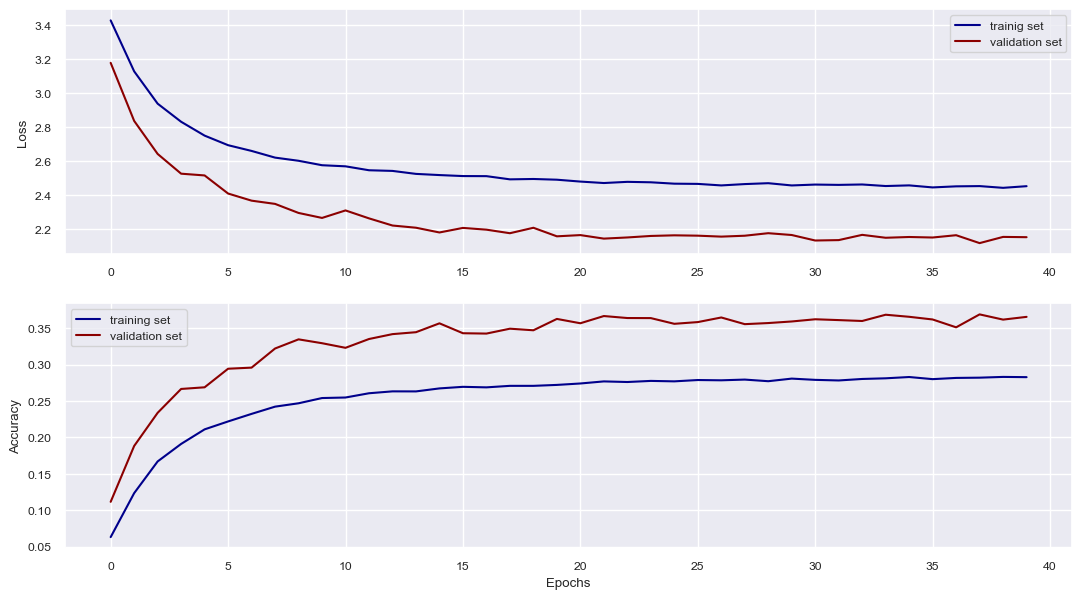

In [31]:
# Plot convergence (loss/accuracy)
training_metrics_plot(history)

**Predict labels in test set**

In [32]:
# Predict labels in test set
names, real, predicted, probs= apply_test_data(test_data, model)

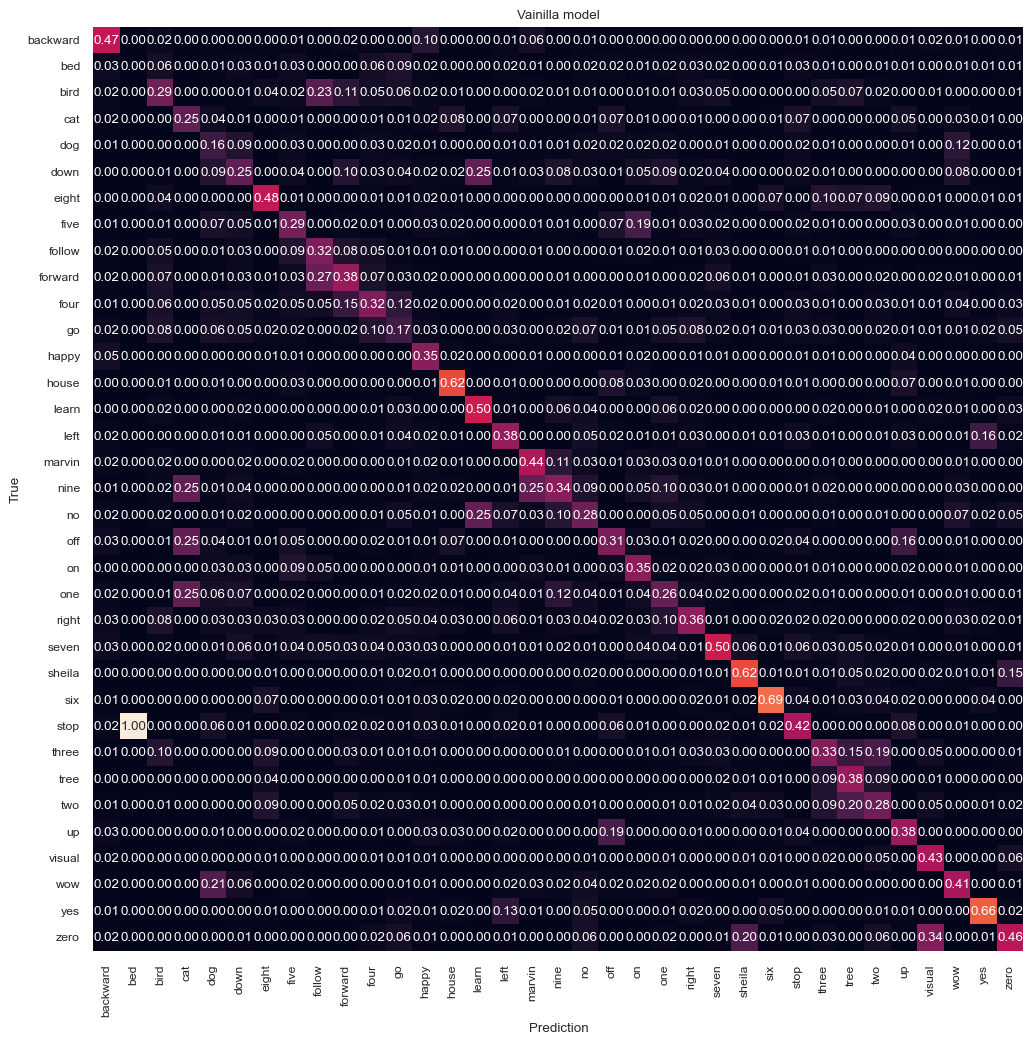

In [33]:
# Plot heatmap
confussion_matrix(real, predicted, audio_labels)

In [35]:
# Worst classified samples
show_missclassified(names, real, predicted, probs,audio_labels, samples = 5)

: 

In [ ]:
# Overall metrics
accuracy, loss = model.evaluate(test_data.map(extract), verbose = 0)
display_metrics(df_tr, loss, accuracy, audio_dataset, names, total_time, number_epochs, feature_type, noise, noise_level)

### **3.4 MFCC + background noise** 

Now, we proceed to test the model using the MFCC. As the previous case, we add background noise.

**Extract audio features**

In [18]:
# Select audio feature extractor
feature_type = MFCC

# Define background noise
noise = True

# Run pipeline
train_data, val_data, test_data= pipeline_setup(audio_dataset, feature_type)

**Model training**

In [ ]:
# Define epochs
number_epochs = 20

# Run model
model, history, total_time = vanilla_model(train_data.map(extract), val_data.map(extract), number_epochs)

ERROR: Could not find file /tmp/ipykernel_4681/2192404939.py
(1, 99, 13)
Model Compiled succesfully
Starting training
Epoch 1/20


2024-07-13 23:20:58.212718: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-07-13 23:20:58.880515: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-07-13 23:20:59.953828: I external/local_xla/xla/service/service.cc:168] XLA service 0x74422c772770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-13 23:20:59.953850: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-07-13 23:20:59.968381: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1720905660.082160    4781 device_compiler.h:186] Compiled clust

1158/1158 [==============================] - 517s 442ms/step - loss: 1.7730 - accuracy: 0.4951 - val_loss: 0.8338 - val_accuracy: 0.7531
Epoch 2/20
1158/1158 [==============================] - 514s 444ms/step - loss: 0.9915 - accuracy: 0.7110 - val_loss: 0.6064 - val_accuracy: 0.8256
Epoch 3/20
 136/1158 [==>...........................] - ETA: 3:14 - loss: 0.8507 - accuracy: 0.7475

**Display training metrics**

In [17]:
# Display training metrics dataframe
df = pd.DataFrame(history.history)
df.to_csv(os.path.join(df_path, 'mfcc_n.txt'), sep='\t', index=False)
df.tail()

,loss,accuracy,val_loss,val_accuracy
35,0.448977,0.869141,0.331351,0.908163
36,0.457070,0.867360,0.324657,0.909864
37,0.451239,0.868359,0.300494,0.917611
38,0.441759,0.870788,0.323197,0.909675
39,0.444012,0.870923,0.311881,0.912415


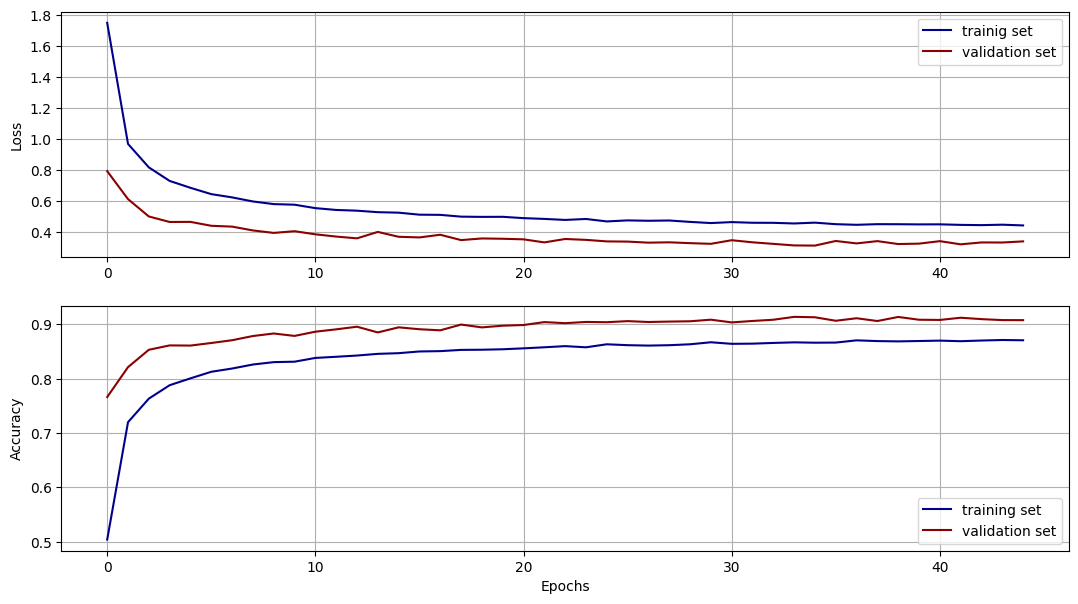

In [41]:
# Display convergence
training_metrics_plot(history)

**Predict labels in test set**

In [18]:
# Obtain predictions on test set
names, real, predicted, probs= apply_test_data(test_data, model)

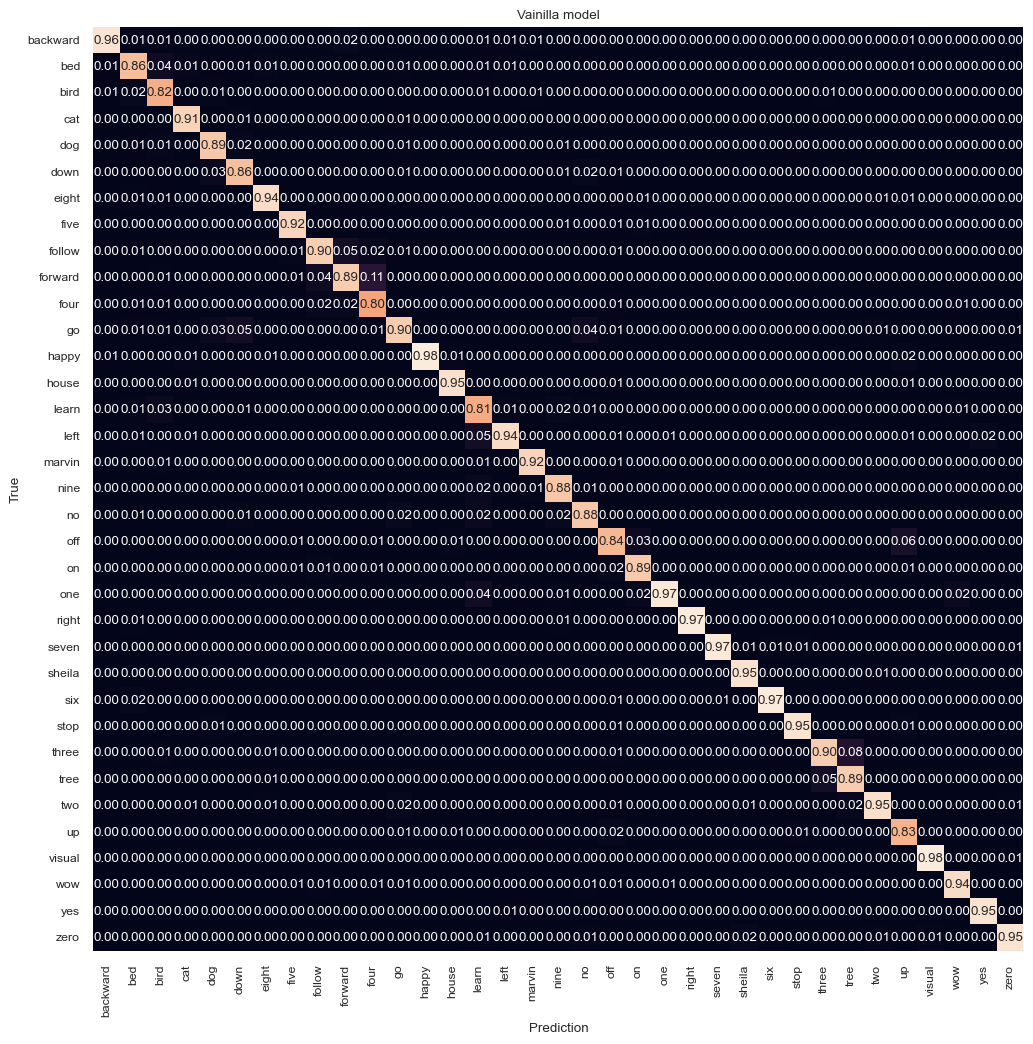

In [19]:
# Display ocnfussion matrix
confussion_matrix(real, predicted, audio_labels)

In [22]:
# Worst classified samples
show_missclassified(names, real, predicted, probs,audio_labels, samples = 5)

-------------------
Example #0
Label: left | Predicted: yes
Probability: 0.9999997615814209


-------------------
Example #1
Label: two | Predicted: tree
Probability: 0.9999974966049194


-------------------
Example #2
Label: visual | Predicted: four
Probability: 0.9999974966049194


-------------------
Example #3
Label: nine | Predicted: marvin
Probability: 0.9999955892562866


-------------------
Example #4
Label: learn | Predicted: bird
Probability: 0.9999954700469971


In [21]:
# Overall metrics
accuracy, loss = model.evaluate(test_data.map(extract), verbose = 0)
display_metrics(df, loss, accuracy, audio_dataset, names, total_time, number_epochs, feature_type, noise, noise_level=0)

--------------------------------------------Model metrics--------------------------------------------

		TRAINING SET			VALIDATION SET			 TEST SET 
Accuracy:	0.8709233403205872		0.9124149680137634		0.9131112694740295
Loss:    	0.4440118074417114		0.31188061833381653		0.3204008936882019

Total samples: 105829
Misclassified samples: 21165

***MODEL SPECIFICATIONS***
Audio feature used: <function MFCC at 0x7ec08919a710>
Number of epochs: 40
Background noise: False
Noise level: 0

***BENCHMARKING***
Training time: 917.7522342205048


### **3.5 MEL-filterbank + background noise**

Here we apply the MEL-filterbank coefficients feature for training the model. 

**Feature extraction**

In [15]:
# Select audio feature extractor
feature_type = Mel_filterbank

# Define background noise
noise = True
noise_level = 0.3

# Run pipeline
train_data, val_data, test_data= pipeline_setup(audio_dataset, feature_type)

**Model training**

In [16]:
# Define epochs
number_epochs = 40

# Run model
model, history, total_time = vanilla_model(train_data.map(extract), val_data.map(extract), number_epochs)

ERROR: Could not find file /tmp/ipykernel_4226/2192404939.py
(1, 99, 26)
Model Compiled succesfully
Starting training
Epoch 1/40


2024-03-09 19:48:47.496045: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-09 19:48:47.873809: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-09 19:48:48.988951: I external/local_xla/xla/service/service.cc:168] XLA service 0x7d98b4769730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-09 19:48:48.988986: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-03-09 19:48:49.005071: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710010129.087727    4519 device_compiler.h:186] Compiled clust

1158/1158 [==============================] - 315s 267ms/step - loss: 2.7007 - accuracy: 0.2477 - val_loss: 1.9562 - val_accuracy: 0.4546
Epoch 2/40
1158/1158 [==============================] - 11s 10ms/step - loss: 1.9525 - accuracy: 0.4390 - val_loss: 1.4434 - val_accuracy: 0.5930
Epoch 3/40
1158/1158 [==============================] - 11s 10ms/step - loss: 1.7019 - accuracy: 0.5103 - val_loss: 1.3642 - val_accuracy: 0.6077
Epoch 4/40
1158/1158 [==============================] - 11s 10ms/step - loss: 1.5868 - accuracy: 0.5439 - val_loss: 1.2555 - val_accuracy: 0.6411
Epoch 5/40
1158/1158 [==============================] - 11s 10ms/step - loss: 1.4901 - accuracy: 0.5692 - val_loss: 1.1606 - val_accuracy: 0.6669
Epoch 6/40
1158/1158 [==============================] - 11s 10ms/step - loss: 1.4252 - accuracy: 0.5866 - val_loss: 1.0991 - val_accuracy: 0.6835
Epoch 7/40
1158/1158 [==============================] - 11s 10ms/step - loss: 1.3715 - accuracy: 0.6041 - val_loss: 1.0610 - val_accu

**Display training metrics**

In [17]:
# Display training metrics dataframe
df = pd.DataFrame(history.history)
df.to_csv(os.path.join(df_path, 'melf_n.txt'), sep='\t', index=False)
df.tail()

,loss,accuracy,val_loss,val_accuracy
35,1.032025,0.692562,0.807814,0.765401
36,1.037312,0.694114,0.774276,0.772581
37,1.016094,0.698920,0.800628,0.770692
38,1.024944,0.698502,0.750819,0.783258
39,1.016583,0.701215,0.762557,0.778439


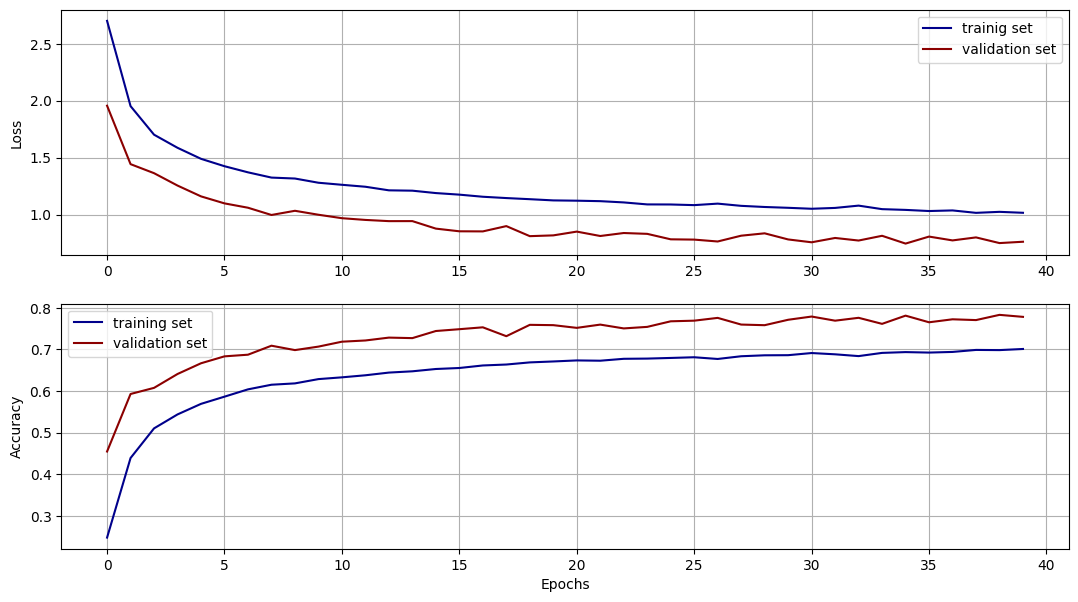

In [20]:
# Display convergence
training_metrics_plot(history)

In [ ]:
sift_100 = tf.keras.models.load_model("SIFT_RNN_100.keras", safe_mode = False)

**Predict labels in test set**

In [21]:
# Obtain predictions on test set
names, real, predicted, probs= apply_test_data(test_data, model)

: 

In [ ]:
# Display ocnfussion matrix
confussion_matrix(real, predicted, audio_labels)

In [ ]:
# Overall metrics
accuracy, loss = model.evaluate(test_data.map(extract), verbose = 0)
display_metrics(df_tr, loss, accuracy, audio_dataset, names, total_time, number_epochs, feature_type, noise, noise_level)

# 4. Summary

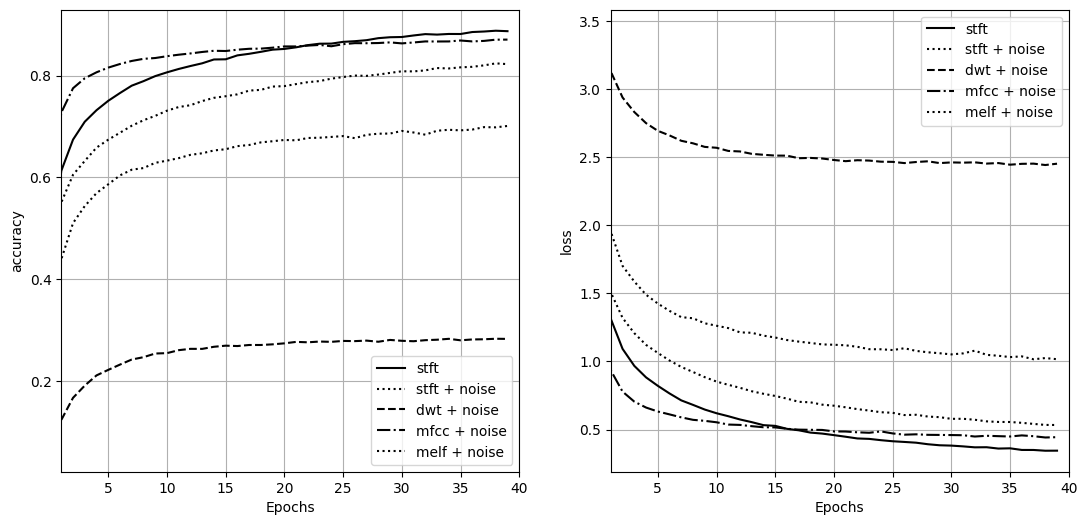

In [133]:
def read_df(df, df_path = "./tests"):
    """
    Extract saved .txt files

    Args:
        df-> dataframes names -> .txt
        
    Return:
        pandas dataframe
    """
    return pd.read_csv(os.path.join(df_path, df), delimiter= "\t")

# Set .txt names
df_names = ["stft.txt", "stft_n.txt", "dwt_n.txt", "mfcc_n.txt", "melf_n.txt"]

# Map function 
df_files = map(read_df, df_names)

def metrics_summary_insipid(object):
    """
    Plot summary evolution of all configurations

    Args:
        object -> mapped object with pandas dataframes
    """

    # Set configuration names
    examples = ["stft", "stft + noise", "dwt + noise", "mfcc + noise", "melf + noise"]
    lines = ["solid", "dotted", "dashed", "dashdot", ":"]
    types = ["accuracy", "loss"]
    args = list(object)
    # Define plotting
    fig, axis = plt.subplots(1,2, figsize = (13,6))
    for typ in range(len(types)):
        for conf in range(len(args)):
            axis[typ].plot(args[conf][types[typ]], color = "black", label = examples[conf], linestyle = lines[conf])
            axis[typ].set_ylabel(types[typ])
            axis[typ].set_xlabel("Epochs")
            axis[typ].set_xlim(1, 40)
            axis[typ].grid("off")
            axis[typ].legend()


metrics_summary_insipid(df_files)        

Here, we decided to use the STFT with noise. It is the fastest and has a high level of accuracy